<a href="https://colab.research.google.com/github/BoboSamson/BoboSamson/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22ZeroClassification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import pipeline, AutoTokenizer
from transformers import pipeline, AutoTokenizer

In [ ]:

# Set device for execution (CPU by default, GPU if available)
device = 0 if torch.cuda.is_available() else -1
print(device)
torch.manual_seed(44)

0


In [ ]:

# Load zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

Device set to use cuda:0


In [ ]:

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

In [ ]:

# Define candidate topics
candidate_labels = [
    "politics", "sports", "technology", "health", "entertainment", "business",
    "education", "food", "travel", "climate", "relationships", "science",
    "religion", "economy", "crime", "military", "fashion", "music", "movies", "personal",
]

In [ ]:
# Load dataset
df = pd.read_csv("/content/merged_sample_sentiment.csv")
df

,timestamp,processed_text,sentiment_score,sentiment_category
0,2024-03,Diary Game for Monday th March Uploaded my boo...,4,positive
1,2024-03,Upvote Upvoted Thank You for sending some of y...,0,negative
2,2024-03,Check my latest fight vs The Goverment a href src,4,positive
3,2024-03,The Diary Game De guardia en CO Steemit Y los ...,4,positive
4,2024-03,Upvote Upvoted Thank You for sending some of y...,0,negative
...,...,...,...,...
21533,2024-11,Me esperando div F padre puso el grito en el c...,1,negative
21534,2024-11,n,0,negative
21535,2024-11,n nn nn,0,negative
21536,2024-11,Israel Increases Pressure On Syria,0,negative


In [ ]:


# Select relevant columns
df = df[["processed_text", "sentiment_score", "sentiment_category"]].dropna()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, candidate_labels):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.candidate_labels = candidate_labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]["processed_text"]
        label = self.dataframe.iloc[idx]["sentiment_category"]

        inputs = self.tokenizer(text, truncation=True, max_length=500, padding="max_length", return_tensors="pt")

        return {
            "input_ids": inputs["input_ids"][0],
            "attention_mask": inputs["attention_mask"][0],
            "label": label
        }

def create_data_loaders(train_df, test_df, tokenizer, candidate_labels, batch_size=32):
    train_dataset = TextClassificationDataset(train_df, tokenizer, candidate_labels)
    test_dataset = TextClassificationDataset(test_df, tokenizer, candidate_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def classify_text(text):
    """Classifies text into a single topic while handling memory efficiency."""
    inputs = tokenizer(text, truncation=True, max_length=500, return_tensors="pt")
    truncated_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)

    result = classifier(truncated_text, candidate_labels, multi_label=False)  # Single-label classification
    return result["labels"][0]  # Top predicted category


In [ ]:
# Sample 3000 rows from the dataset
# If the dataset has less than 3000 rows, sample the entire dataset
sample_size = min(3000, len(df))
df_sampled = df.sample(n=sample_size, random_state=44).reset_index(drop=True)

# Train-test split
train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=44)
print("Sampled dataset shape:", df_sampled.shape)
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Sampled dataset shape: (3000, 3)
Train set shape: (2400, 3)
Test set shape: (600, 3)


In [ ]:
def process_data(dataset, batch_size=32): # Added batch_size for DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_predictions = []
    for batch in tqdm(data_loader, total=len(data_loader), desc="Processing Texts"):
        input_ids = batch["input_ids"].to(device) # Move inputs to the appropriate device (CPU or GPU)
        attention_mask = batch["attention_mask"].to(device)

        # Correct the classifier call
        with torch.no_grad(): # Disable gradient calculation during inference
            # Construct input sequences from input_ids and attention_mask
            input_sequences = [tokenizer.decode(ids, skip_special_tokens=True)
                              for ids in input_ids]

            outputs = classifier(input_sequences, candidate_labels=candidate_labels, multi_label=False)

        predictions = [output["labels"][0] for output in outputs] # Extract predictions
        all_predictions.extend(predictions)

    # Add predictions to the original DataFrame
    dataset.dataframe["predicted_category"] = all_predictions # Assuming dataset.dataframe is accessible
    return dataset.dataframe # Return the modified DataFrame

In [ ]:
# Create train datasets
train_dataset = TextClassificationDataset(train_df, tokenizer, candidate_labels)


# Process train data using the modified function
train_df = process_data(train_dataset)



Processing Texts: 100%|██████████| 75/75 [43:41<00:00, 34.95s/it]


In [ ]:
#Create test datasets
test_dataset = TextClassificationDataset(test_df, tokenizer, candidate_labels)

#Process test data
test_df = process_data(test_dataset)


Processing Texts: 100%|██████████| 19/19 [10:52<00:00, 34.34s/it]


predicted_category
personal         201
technology        97
entertainment     68
relationships     47
food              33
business          31
travel            28
health            23
sports            13
education         11
economy            9
music              8
politics           8
military           6
religion           4
climate            4
fashion            3
crime              3
science            2
movies             1
Name: count, dtype: int64


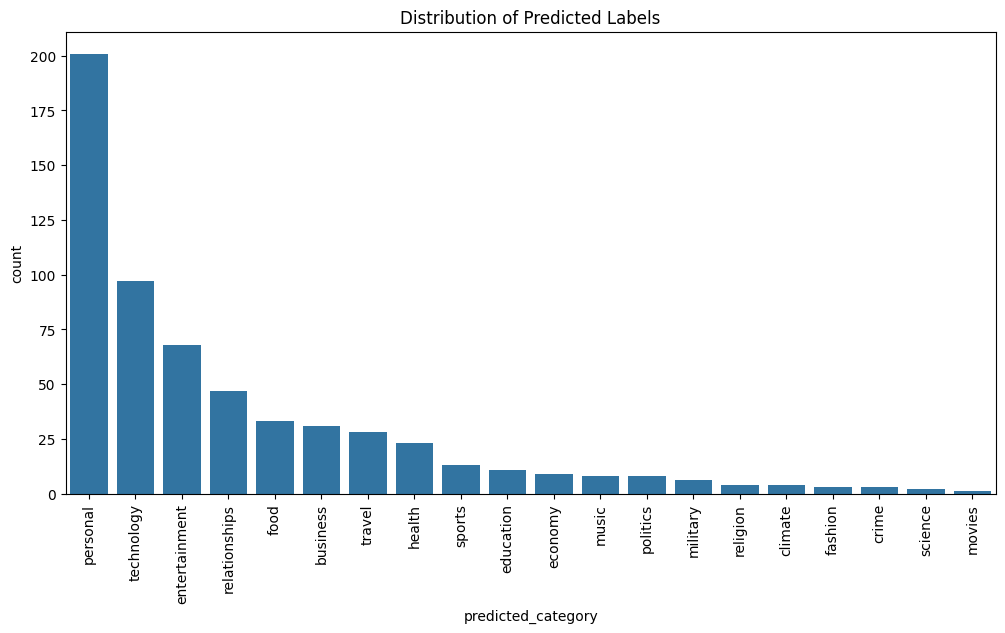

In [ ]:
# Analyze predicted label distribution
predicted_label_counts = test_df['predicted_category'].value_counts()
print(predicted_label_counts)

# Visualize the distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='predicted_category', data=test_df, order=predicted_label_counts.index)
plt.xticks(rotation=90)
plt.title('Distribution of Predicted Labels')
plt.show()

This code snippet calculates and prints the frequency of each predicted label in the test_df DataFrame. It then visualizes the distribution using a bar chart created with seansborn and matplotlib. This visualization provides a clear overview of how the model is categorizing your texts.